In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
from classifiers import SVM, MultiClassClassifier

In [5]:
class Kernel():
  def __init__(self, name='linear', sigma=0.1):
    self.name = name
    self.sigma = sigma

  def matrix(self, x, y):
    if self.name == 'rbf':
      K = np.exp(-np.sum((x[:, None, :] - y[None, :, :])**2, -1) / (2*self.sigma))
    if self.name == 'linear':
      K = x @ y.T

    #print(np.linalg.eigh(K))
    return K #+ np.eye(self.n) * 1e-8

## Image data

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

!kaggle competitions download -c data-challenge-kernel-methods-2023-2024

 95% 97.0M/102M [00:00<00:00, 124MB/s]
100% 102M/102M [00:00<00:00, 122MB/s] 


In [7]:
!unzip data-challenge-kernel-methods-2023-2024.zip -d data

Archive:  data-challenge-kernel-methods-2023-2024.zip
  inflating: data/Xte.csv            
  inflating: data/Xtr.csv            
  inflating: data/Ytr.csv            


In [8]:
from data_processing import load_data
import pandas as pd

In [9]:
rescale = lambda data: (data-data.min())/(data.max()-data.min())

In [10]:
data = load_data("data/Xtr.csv")
data = rescale(data)
labels = pd.read_csv('data/Ytr.csv')['Prediction'].to_numpy()

test_data = load_data("data/Xte.csv")
test_data = rescale(test_data)

In [11]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

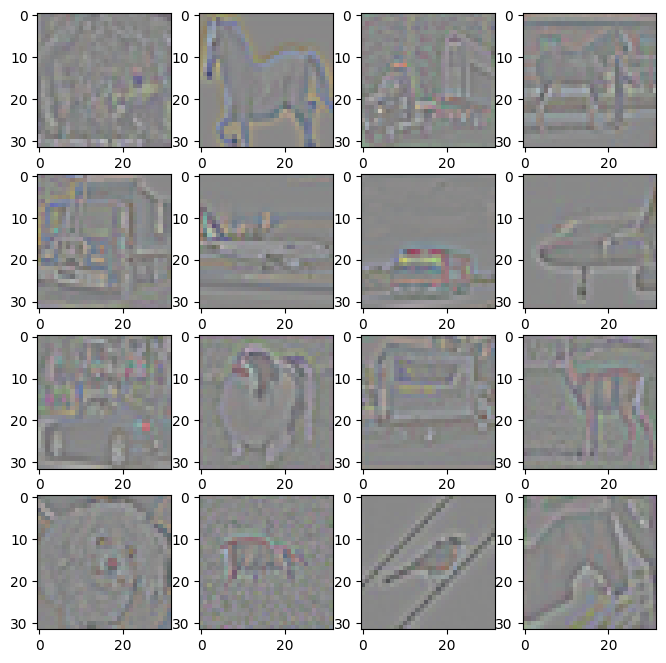

In [5]:
cols, rows = 4,4
fig = plt.figure(figsize=(8, 8))
for i in range(cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(data[i])
plt.show()

In [12]:
np.random.seed(0)
val_idx = np.random.choice(np.arange(len(data)), len(data)//5, replace=False)
mask = np.ones(len(data), dtype=bool)
mask[val_idx] = 0

val_data = data[val_idx]
val_labels = labels[val_idx]

train_data = data[mask]
train_labels = labels[mask]

len(val_data), len(train_data)

(1000, 4000)

In [45]:
train_data.shape

(4000, 32, 32, 3)

In [13]:

class HOGExtractor:
    """
    Class to extract HOG features from images

    Implementation with signed gradients and no block normalization

    Attributes:
    - cell_size: size of the cell in pixels
    - nbins: number of bins in the histogram
    """

    def __init__(self, cell_size=8, nbins=9):
        self.cell_size = cell_size
        self.nbins = nbins

    def extract_from_dataset(self, dataset):
        """
        Extract HOG features from a dataset of images

        Arguments:
        - dataset: a 4D numpy array representing the dataset

        Returns:
        - features: a 2D numpy array containing the HOG features
        """
        # Compute the gradient
        h = dataset.shape[1]
        w = dataset.shape[2]
        c = dataset.shape[-1]

        gx = np.gradient(dataset, axis=2)
        gy = np.gradient(dataset, axis=1)
        magnitude = np.sqrt(gx**2 + gy**2)
        angle = (np.pi + np.arctan2(gy, gx)) % np.pi #np.arctan2(gy, gx)

        # Compute the histogram
        features = []
        for i in range(0, h - self.cell_size + 1, self.cell_size):
            for j in range(0, w - self.cell_size + 1, self.cell_size):
                cell_magnitude = magnitude[:, i : i + self.cell_size,
                                           j : j + self.cell_size].reshape(len(dataset), -1, c)
                cell_angle = angle[:, i : i + self.cell_size,
                                   j : j + self.cell_size].reshape(len(dataset), -1, c)

                hist = np.zeros((len(dataset), c, self.nbins))

                bin1 = (cell_angle / (np.pi / self.nbins)).astype(int) % self.nbins

                bin2 = (bin1 + 1) % self.nbins
                weight = (cell_angle % (np.pi / self.nbins)) / (np.pi / self.nbins)

                for val in range(self.nbins):
                 # print(val, (bin1 == val).sum())
                  hist[:, :, val] = np.sum(cell_magnitude * (1 - weight) * (bin1 == val), 1)
                  hist[:, :, val] += np.sum(cell_magnitude * weight * (bin2 == val), 1)

                features.append(hist)

        features = np.concatenate(features, 2).reshape(len(dataset), -1)
        return features

In [32]:
import hog_extractor
#import importlib
#importlib.reload(hog_extractor)

<module 'hog_extractor' from '/content/hog_extractor.py'>

In [15]:
from time import time

In [61]:
hog = hog_extractor.HOGExtractor()
st = time()
val_dataset_1 = hog.extract_from_dataset(val_data)
print(time() - st)

11.29731798171997


In [108]:
new_hog = HOGExtractor()
st = time()
val_dataset_2 = new_hog.extract_from_dataset(val_data)
print(time() - st)

1.5652246475219727


In [110]:
np.allclose(val_dataset_1, val_dataset_2)

True

In [14]:
hog = HOGExtractor()

train_dataset = hog.extract_from_dataset(train_data)
val_dataset = hog.extract_from_dataset(val_data)
test_dataset = hog.extract_from_dataset(test_data)

In [ ]:
simple_kernel = Kernel('linear')
svm = SVM(simple_kernel)
cl = MultiClassClassifier(num_classes=10, model=svm)
cl.fit(train_dataset[:1000], train_labels[:1000])

#cl = MultiClassClassifier(num_classes=10, model=svm, method='pairwise')
#cl.fit(train_dataset[:1000], train_labels[:1000])

y_val = cl.predict(val_dataset)
y_test = cl.predict(test_dataset)

In [19]:
np.mean(y_val == val_labels)

0.295

In [ ]:
simple_kernel = Kernel('rbf')
svm = SVM(simple_kernel)
cl = MultiClassClassifier(num_classes=10, model=svm)
cl.fit(train_dataset, train_labels)

y_val = cl.predict(val_dataset)
y_test = cl.predict(test_dataset)

In [17]:
np.mean(y_val == val_labels)

0.28